In [132]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mpmath 

In [133]:
m_e=0.511 #Mev
m_mu=105.658 #Mev
m_tau=1776.86 #Mev
m_charge=[m_e,m_mu,m_tau]
pi=np.pi
G = 6.71*10**-45 # MeV
Mpl = (8 * pi * G) ** (-0.5)
yinf=4.35*10**-7 # Divided by the mass of the particle
y0=0.0
geff=3

In [134]:
data = np.loadtxt('g_*s(T).txt', skiprows=1)
t_imported = data[:, 0]
g_star_s_imported = data[:, 1]
def g_star_s_interp_func(t):
    return sp.interpolate.interp1d(t_imported, g_star_s_imported, fill_value="extrapolate")(t)

In [135]:
def bk(n,x):
    return sp.special.kn(n,x)

def gmeijer1(x):
    x_mpf = mpmath.mpf(x)
    try:
        return float(mpmath.meijerg([[], [1]], [[-1/2, -1/2, 1/2], []], x_mpf**2))
    except (ValueError, mpmath.libmp.libhyper.HypercombError):
        return 0.0 

def gmeijer2(x):
    x_mpf = mpmath.mpf(x)
    try:
        return float(mpmath.meijerg([[], [2]], [[-1/2, 1/2, 1/2], []], x_mpf**2))
    except (ValueError, mpmath.libmp.libhyper.HypercombError):
        return 0.0 

In [136]:
def int_n_e(E, m, T):
    arg = E / T
    arg = np.clip(arg, None, 700)  # Avoid overflow in exp
    return E * np.sqrt(E**2 - m**2) / (np.exp(arg) + 1)

def n_e(m,T,glib):
    int=[]
    if m>0:
        int.append(sp.integrate.quad(int_n_e,m,m*10,args=(m,T),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
        for i in range(10):
            int.append(sp.integrate.quad(int_n_e,m*10**(i+1),m*10**(i+2),args=(m,T),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
        int1=np.sum(int)
        return (glib/(2*np.pi**2))*int1
    elif m==0:
        int.append(sp.integrate.quad(int_n_e,0,1,args=(0,T),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
        for i in range(10):
            int.append(sp.integrate.quad(int_n_e,10**i,10**(i+1),args=(0,T),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
        int1=np.sum(int)
        return (glib/(2*np.pi**2))*int1
    else:
        print('Error: Negative mass')
        return 0

In [137]:
def n_nu(T,glib):                                              # If Dirac fermions glib=4
    return 3*glib*sp.special.zeta(3)*T**3/(4*np.pi**2)         # If Majorana fermions glib=2 

def rho_nu(T,glib):                                                 # If Dirac fermions glib=4
    return (7*glib*np.pi**2*T**4)/(240)                        # If Majorana fermions glib=2 

def p_nu(T,glib):
    return (1/3)*rho_nu(T,glib)

def s_nu(T,glib):
    return (4*rho_nu(T,glib))/(3*T)

def Y_nu(T,glib):
    return n_nu(T,glib)/s_nu(T,glib)    

In [138]:
def sigma_e(s,g,mchi,me):
    sigma1=g**2/(16*pi*s**3)
    sigma2=np.sqrt((s-4*mchi**2)/(s-4*me**2))
    sigma31=(s**2+((s-4*me**2)*(s-4*mchi**2))/(3))
    sigma32=4*mchi**2*(s-2*me**2)
    sigma33=4*me**2*(s-2*mchi**2)
    sigma34=16*mchi**2*me**2
    return sigma1*sigma2*(sigma31+sigma32+sigma33+sigma34)

def intsigma_e(s,g,mchi,T,me):
    intsigma1=sigma_e(s,g,mchi,me)
    intsigma2=(s-4*mchi**2)
    intsigma3=np.sqrt(s)
    intsigma4=bk(1,np.sqrt(s)/T)
    return intsigma1*intsigma2*intsigma3*intsigma4

def sigmav_e(g,mchi,T,me):
    int=[]
    n=30
    for i in range(n):
        int.append(sp.integrate.quad(intsigma_e,2**(2*i+2)*max(mchi**2,me**2),2**(2*i+4)*max(mchi**2,me**2),args=(g,mchi,T,me),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
    int.append(sp.integrate.quad(intsigma_e,2**(2*n+3)*max(mchi**2,me**2),np.inf,args=(g,mchi,T,me),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
    int2=np.sum(int)
    if int2==0.0:
        #print("Warning: sigmav_e is zero, returning 0")
        return 0.0
    c1=8*mchi**4*T*bk(2,mchi/T)**2
    return (int2)/c1


In [139]:
def dYdx_e(y,x,g,mchi,me):
    a1=sigmav_e(g,mchi,mchi/x,me)
    a2=n_e(me,mchi/x,4)
    a3=((2*pi**2)/45)*(mchi/x)**3*g_star_s_interp_func(mchi/x)
    a4=(pi*(mchi/x)**2)*np.sqrt(g_star_s_interp_func(mchi/x)/90)/Mpl
    return 2*a1*a2**2/(x*a3*a4)

In [140]:
def sigma_nu(s,g,mchi):
    a1=g**2/(32*pi*s**2)
    a2=np.sqrt((s-4*mchi**2)/(s))
    a3=(s+(s-4*mchi**2)/(3)+4*mchi**2)
    return a1*a2*a3

def intsigma_nu(s,g,mchi,T):
    a1=sigma_nu(s,g,mchi)
    a2=(s-4*mchi**2)
    a3=np.sqrt(s)
    a4=bk(1,np.sqrt(s)/T)
    return a1*a2*a3*a4

def sigmav_nu_num(g,mchi,x):
    int=[]
    n=50
    for i in range(n):
        int.append(sp.integrate.quad(intsigma_nu,2**(2*i+2)*mchi**2,2**(2*i+4)*mchi**2,args=(g,mchi,mchi/x),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
    int.append(sp.integrate.quad(intsigma_nu,2**(2*n+3)*mchi**2,np.inf,args=(g,mchi,mchi/x),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
    int2=np.sum(int)
    if int2==0.0:
        #print("Warning: sigmav_e is zero, returning 0")
        return 0.0
    a1=x/(8*mchi**5*bk(2,x)**2)
    return a1*(int2)

def dYdx_nu_num(y,x,g,mchi):
    a1=sigmav_nu_num(g,mchi,x)
    a2=n_nu(mchi/x,2)
    a3=((2*pi**2)/45)*(mchi/x)**3*g_star_s_interp_func(mchi/x)
    a4=(pi*(mchi/x)**2)*np.sqrt(g_star_s_interp_func(mchi/x)/90)/Mpl
    return 2*a1*a2**2/(x*a3*a4)

In [141]:
# physical constant: final (instantaneous-decoupling) ratio
TNU_OVER_TGAMMA_infty = (4.0/11.0)**(1.0/3.0)  # ~0.713766

def Tnu_over_Tgamma_approx(T_gamma_MeV, Tdec=0.511, width=0.6):
    x = np.array(T_gamma_MeV, dtype=float)
    s = np.tanh((x - Tdec) / width)  
    r = 0.5*(1.0 + s) * 1.0 + 0.5*(1.0 - s) * TNU_OVER_TGAMMA_infty
    return r

def Tnu_from_Tgamma(T_gamma_MeV, **kwargs):
    return Tnu_over_Tgamma_approx(T_gamma_MeV, **kwargs) * np.array(T_gamma_MeV, dtype=float)

In [142]:
def sigmav_nu(g, mchi, x):
    bk2 = bk(2, x)
    denom = 192 * pi * mchi**3 * bk2**2
    num = (4 * mchi * bk(1, x)**2) - (np.sqrt(pi) * mchi * x * (gmeijer1(x) + gmeijer2(x)))
    return (g**2 / denom) * num

def dYdx_nu(y,x,g,mchi):
    T= mchi/x
    T_nu = Tnu_from_Tgamma(T)               # We change the temperature to T_nu for the yield computations but not the evolution of the universe
    x_nu = mchi/T_nu  
    a1=sigmav_nu(g,mchi,x_nu)
    a2=n_nu(mchi/x_nu,6)               # glib=6 for 3 neutrino species
    a3=((2*pi**2)/45)*(mchi/x)**3*g_star_s_interp_func(mchi/x)
    a4=(pi*(mchi/x)**2)*np.sqrt(g_star_s_interp_func(mchi/x)/90)/Mpl
    return 2*a1*a2**2/(x*a3*a4)

def dYdx_nu_mod(y,x,g,mchi):
    a1=sigmav_nu(g,mchi,x)
    a2=n_nu(mchi/x,6)               # glib=6 for 3 neutrino species
    a3=((2*pi**2)/45)*(mchi/x)**3*g_star_s_interp_func(mchi/x)
    a4=(pi*(mchi/x)**2)*np.sqrt(g_star_s_interp_func(mchi/x)/90)/Mpl
    return 2*a1*a2**2/(x*a3*a4)

In [143]:
# Load the data from the file
filename = f"gCvsgnu_mchi_10.txt"
data = np.loadtxt(filename)

# Split the data into two arrays
gC= data[:, 0]  # First column
yield_C= data[:, 1]  # Second column



In [144]:
# Load the data from the file
filename_gNuvsgC = "gNuvsgC_10.txt"
data_gNuvsgC = np.loadtxt(filename_gNuvsgC)

# Split the data into two arrays
gNu = data_gNuvsgC[:, 0]  # First column
yield_Nu = data_gNuvsgC[:, 1]  # Second column


In [145]:
from scipy.interpolate import interp1d

# Create the interpolating function
interp_column1_from_column2 = interp1d(yield_Nu, gNu, fill_value="extrapolate")

value_column2 = 5e-12  # Replace with your desired value
gC_plot=[]
gNu_plot=[]
for i in range(len(gC)):
    if yinf/10-yield_C[i]>0:
        gC_plot.append(gC[i])
        gNu_plot.append(interp_column1_from_column2(yinf/10-yield_C[i]))



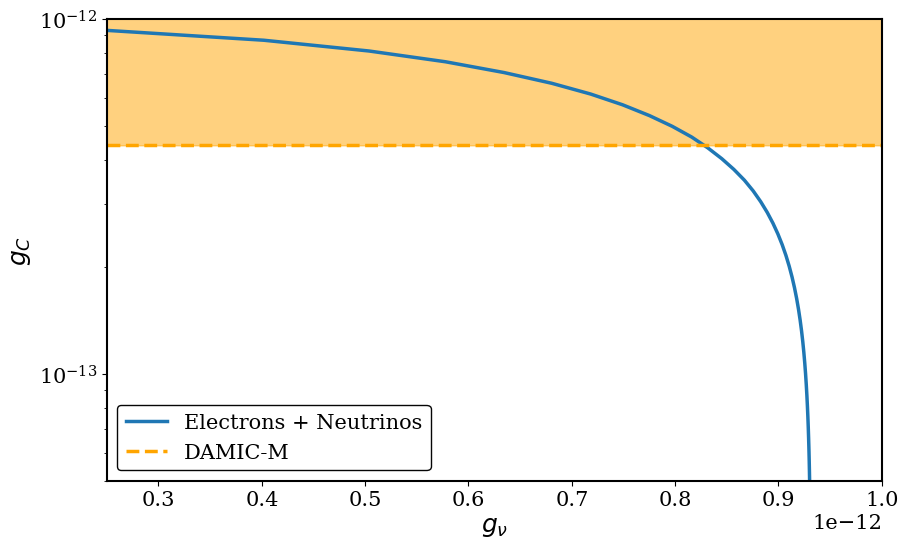

In [157]:
import matplotlib as mpl
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 16,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "legend.fontsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "axes.linewidth": 1.5,
    "lines.linewidth": 2.5,
    "legend.frameon": True,
    "legend.framealpha": 0.98,
    "legend.fancybox": True,
    "legend.edgecolor": "black",
    "text.usetex": False,
})
plt.figure(figsize=(10, 6))

x_test = np.linspace(2*10**-13,10**-12, 1000)
x_test2 = np.linspace(10**-14,10**-12, 1000)
y_test1 = 4.4*10**-13 * np.ones_like(x_test)
y_test2= 10**-12 * np.ones_like(x_test)


plt.plot(gNu_plot, gC_plot, label='Electrons + Neutrinos')
plt.axhline(y=4.4*10**-13, color='orange', linestyle='--', label='DAMIC-M')
plt.fill_between(x_test,y_test1,y_test2,color='orange',alpha=0.5)
plt.xlim(2.5*10**-13,10**-12)
plt.ylim(5*10**-14,10**-12)
plt.xlabel(fr'$g_\nu$')
plt.ylabel(fr'$g_C$')
plt.yscale('log')
plt.legend()

In [147]:
mchi=[10]
x=np.logspace(-8,2,5000)
g_charge=[4.4*10**-13]
temp=[]
yplot_e=[]
yplot_mu=[]
yplot_tau=[]
yplot_total=[]
for i in range(len(mchi)):
    temp=[]
    for j in range(len(m_charge)):
        y_charge=sp.integrate.odeint(dYdx_e, y0, x,args=(g_charge[i],mchi[i],m_charge[j]), rtol=1e-12, atol=1e-12, mxstep=10000)
        temp.append(y_charge)
    yplot_total.append(np.sum(temp, axis=0))
    yplot_e.append(temp[0])
    yplot_mu.append(temp[1])
    yplot_tau.append(temp[2])

In [148]:
g_nu=[0.83*10**-12]  # Example values for g_nu, can be modified as needed
yplot_nu1=[]
yplot_nu=[]
#yplot2=[]
#yplot3=[]
for i in range(len(mchi)):
    #y_nu1=sp.integrate.odeint(dYdx_nu,y0,x,args=(g_nu,mchi[i]),rtol=1e-12, atol=1e-12, mxstep=10000)
    y_nu=sp.integrate.odeint(dYdx_nu,y0,x,args=(g_nu[i],mchi[i]),rtol=1e-12, atol=1e-12, mxstep=10000)
    #yplot_nu1.append(y_nu1)
    yplot_nu.append(y_nu)
    print("Process is at ", i+1, " of ", len(mchi))

Process is at  1  of  1


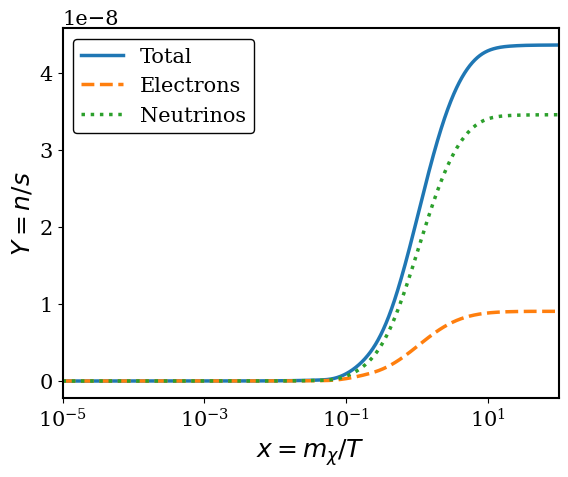

In [156]:
yplot_sum = np.array(yplot_nu[0]) + np.array(yplot_total[0])
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 16,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "legend.fontsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "axes.linewidth": 1.5,
    "lines.linewidth": 2.5,
    "legend.frameon": True,
    "legend.framealpha": 0.98,
    "legend.fancybox": True,
    "legend.edgecolor": "black",
    "text.usetex": False,
})
plt.plot(x, yplot_sum, label = 'Total')
plt.plot(x, yplot_total[0], label = 'Electrons', linestyle = 'dashed')
plt.plot(x, yplot_nu[0], label = 'Neutrinos', linestyle = 'dotted')
plt.xlabel(fr'$x=m_\chi/T$')
plt.ylabel(fr'$Y=n/s$')
plt.xscale('log')
#plt.yscale('log')
#plt.ylim(10**-14, 10**-6)
plt.xlim(10**-5, 10**2)
plt.legend()
plt.show()
